In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
from source.utils import *
from source.classes import *
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

In [3]:
with open('../../Desktop/DLC_social_1/DLC_social_1_exp_conditions.pickle', 'rb') as handle:
    Treatment_dict = pickle.load(handle)

In [10]:
DLC_social_1 = get_coordinates(path='../../Desktop/DLC_social_1/',#Path where to find the required files
                               p=16,                              #Number of processes used for parallelization
                               smooth_alpha=0.1,                    #Alpha value for exponentially weighted smoothing
                               distances=['B_Center','B_Nose','B_Left_ear','B_Right_ear','B_Left_flank',
                                          'B_Right_flank','B_Tail_base'],
                               ego=False,
                               arena='circular',                  #Type of arena used in the experiments
                               arena_dims=[380],                  #Dimensions of the arena. Just one if it's circular
                               video_format='.mp4',
                               table_format='.h5',
                               exp_conditions=Treatment_dict)

In [11]:
DLC_social_1_coords = DLC_social_1.run(verbose=True)

Loading and smoothing trajectories...


  0%|          | 0/47 [00:00<?, ?it/s]

Computing distance based coordinates...


100%|██████████| 47/47 [03:33<00:00,  4.53s/it]

Done!


In [6]:
test = DLC_social_1_coords.get_coords(center=True, polar=False)

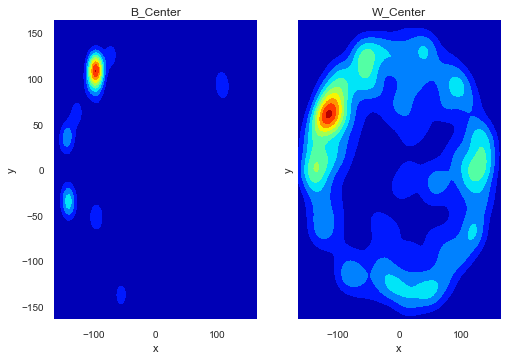

In [7]:
test.plot_heatmaps(['B_Center', 'W_Center'], i=1)

In [17]:
test = DLC_social_1_coords.get_distances()

In [18]:
test._type

'dist'

# Angle computing draft 

In [ ]:
#Which angles to compute?
bp_net = {'B_Nose':['B_Left_ear','B_Right_ear'],
          'B_Left_ear':['B_Nose','B_Right_ear','B_Center','B_Left_flank'],
          'B_Right_ear':['B_Nose','B_Left_ear','B_Center','B_Right_flank'],
          'B_Center':['B_Left_ear','B_Right_ear','B_Left_flank','B_Right_flank','B_Tail_base'],
          'B_Left_flank':['B_Left_ear','B_Center','B_Tail_base'],
          'B_Right_flank':['B_Right_ear','B_Center','B_Tail_base'],
          'B_Tail_base':['B_Center','B_Left_flank','B_Right_flank']}

In [ ]:
import networkx as nx
bp_net = nx.Graph(bp_net)

In [ ]:
nx.draw(bp_net, with_labels=True)

In [ ]:
all_cliques = nx.enumerate_all_cliques(bp_net)
all_cliques = [i for i in all_cliques if len(i) == 3]

In [ ]:
import numpy as np

a = np.array([32.49, -39.96])
b = np.array([31.39, -39.28])
c = np.array([31.14, -38.09])


def angle(a,b,c, degrees=False):

    ba = a - b
    bc = c - b

    cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
    angle = np.arccos(cosine_angle)
    
    if degrees:
        return np.degrees(angle)
    
    return angle

In [ ]:
def angle_trio(array, degrees=False):
    
    a, b, c = array[:,0], array[:,1], array[:,2]
    
    return np.array([angle(a, b, c, degrees=degrees),
                     angle(a, c, b, degrees=degrees),
                     angle(b, a, c, degrees=degrees)])

In [ ]:
example = DLC_social_1_coords.get_coords(center=False, polar=False)['Day2Test13DLC']

In [ ]:
%%time
angle_trio(a, b, c, degrees=True)

In [ ]:
example

In [ ]:
angle_trio(np.array(example[all_cliques[0]]).reshape(14999,3,2))